In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM

# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 200
NUM_CLASSES = 4 # 클래스 개수
CLASS_MODE = 'categorical'

BASE_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project'
ORIGINAL_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/inputdata_preprocessing/img'
AUGMENT_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/inputdata_preprocessing/augmentImg'
train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

In [4]:
%pwd
%cd '/content/drive/MyDrive/Final_project/PlayData_Final_Project'

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


# 데이터 LSTM에 맞게 전처리

In [35]:
# 전체 csv는 20(frame수), 4 의 size로 구성 가정
# 결측치 없다고 가정
# 라벨링은 각 동작 csv의 라벨(동작 번호)를 통해

# 학습데이터 및 모델 경로 설정
csv_dir = './inputdata_preprocessing/csv'
csv_name = '통합문서1.csv' # csv파일이름 저장하기!!!!!!!########

# (20,4), 프레임*(x,y)로 원하는 학습데이터 형태로 분할
IMAGE_SIZE = (640, 360)
DATA_FRAME = 20
INPUT_SHAPE = (DATA_FRAME, 4) # xy쌍 2개
data_X, data_y = [], []
label_list = [dir for dir in os.listdir(csv_dir) if os.path.isdir(os.path.join(csv_dir, dir))] # [다음, 이전, ...]
# print(label_list)
for label, label_name in enumerate(label_list):
  now_label_path = os.path.join(csv_dir, label_name)
  csv_list = [fname for fname in os.listdir(now_label_path) if os.path.splitext(fname)[-1]=='.csv']
  # print(csv_list)
  # csv파일 읽어오기
  for csv_name in csv_list:
    df = pd.read_csv(os.path.join(now_label_path, csv_name), header=None)

    # MinMaxScaler가 아닌 캔버스 크기 대비 위치 비율로 data 스케일링 진행
    for i in range(4):
      df[df.columns[i]] = df[df.columns[i]]/IMAGE_SIZE[i%2]
      
    data_X.append(df)
    data_y.append(label)

# label은 OneHotEncoding
data_y = keras.utils.to_categorical(data_y) # 알아서 shape 관리 잘되는지 확인!!!!
# print(data_y)

to_shuff_all = [[x,y] for x, y in zip(data_X, data_y)]
random.shuffle(to_shuff_all)
data_X = [tmp[0] for tmp in to_shuff_all]
data_y = [tmp[1] for tmp in to_shuff_all]

# train, val, test 분리
train_idx = int(len(data_y)*0.7)
val_idx = int(len(data_y)*0.9)

X_train, y_train = np.array(data_X[:train_idx]), np.array(data_y[:train_idx])
X_val, y_val = np.array(data_X[:val_idx]), np.array(data_y[:val_idx])
X_test, y_test = np.array(data_X[val_idx:]), np.array(data_y[val_idx:])

In [45]:
data_X[:15]

[           0         1    2    3
 0   0.521875  0.250000  0.0  0.0
 1   0.500000  0.263889  0.0  0.0
 2   0.476562  0.286111  0.0  0.0
 3   0.454688  0.305556  0.0  0.0
 4   0.429688  0.330556  0.0  0.0
 5   0.401562  0.355556  0.0  0.0
 6   0.373437  0.380556  0.0  0.0
 7   0.343750  0.450000  0.0  0.0
 8   0.334375  0.475000  0.0  0.0
 9   0.323437  0.502778  0.0  0.0
 10  0.320312  0.538889  0.0  0.0
 11  0.320312  0.569444  0.0  0.0
 12  0.323437  0.605556  0.0  0.0
 13  0.332813  0.644444  0.0  0.0
 14  0.343750  0.675000  0.0  0.0
 15  0.368750  0.705556  0.0  0.0
 16  0.384375  0.719444  0.0  0.0
 17  0.407813  0.730556  0.0  0.0
 18  0.437500  0.794444  0.0  0.0
 19  0.459375  0.838889  0.0  0.0,            0         1    2    3
 0   0.565625  0.369444  0.0  0.0
 1   0.565625  0.369444  0.0  0.0
 2   0.565625  0.358333  0.0  0.0
 3   0.559375  0.355556  0.0  0.0
 4   0.550000  0.358333  0.0  0.0
 5   0.534375  0.369444  0.0  0.0
 6   0.507812  0.397222  0.0  0.0
 7   0.487500 

# 모델 구현

In [51]:
def create_model():
  model = tf.keras.Sequential()
  model.add(layers.Input((DATA_FRAME,4)))
  model.add(layers.LSTM(20, activation='relu', return_sequences=False))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

  return model

In [52]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20)                2000      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
batch_normalization_5 (Batch (None, 10)                40        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 44        
Total params: 2,294
Trainable params: 2,274
Non-trainable params: 20
_________________________________________________________________


In [60]:
MODEL_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/model/lstm'
if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH, exist_ok=True)
# model = keras.models.load_model(os.path.join(MODEL_PATH)) # 직전 모델 로딩하여 재개

if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH, exist_ok=True)
callback_path = os.path.join(MODEL_PATH, 'save_model.ckpt')
mc_callback = keras.callbacks.ModelCheckpoint(callback_path, monitor='val_loss', save_best_only=True)

# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 40
N_BATCHS = 50

N_TRAIN, N_TEST = X_train.shape[0], X_test.shape[0]
steps_per_epoch = N_TRAIN // N_BATCHS
validation_steps = int(np.ceil(N_TEST / N_BATCHS))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(N_BATCHS)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset, validation_steps=validation_steps,
                    callbacks=[mc_callback])

Epoch 1/40
5/5 [==============================] - 1s 11ms/step - loss: 0.9130 - accuracy: 0.4480 - val_loss: 1.5733 - val_accuracy: 0.1750
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final_project/PlayData_Final_Project/model/lstm/save_model.ckpt/assets
Epoch 2/40
5/5 [==============================] - 0s 10ms/step - loss: 0.9495 - accuracy: 0.4560 - val_loss: 1.5782 - val_accuracy: 0.1750
Epoch 3/40
5/5 [==============================] - 0s 10ms/step - loss: 0.9158 - accuracy: 0.4760 - val_loss: 1.3437 - val_accuracy: 0.1750
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final_project/PlayData_Final_Project/model/lstm/save_model.ckpt/assets
Epoch 4/40
5/5 [==============================] - 0s 11ms/step - loss: 1.0414 - accuracy: 0.4600 - val_loss: 1.4951 - val_accuracy: 0.1750
Epoch 5/40
5/5 [==============================] - 0s 10ms/step - loss: 1.0991 - accuracy: 0.3800 - val_loss: 1.4417 - val_accuracy: 0.3000
Epoch 6/40
5/5 [==============================]

In [50]:
model.evaluate(val_dataset)
model.evaluate(test_dataset)

# h5형식으로 저장
model_h5_path = os.path.join(MODEL_PATH, 'lstm_model.h5')

1/1 [==============================] - 0s 18ms/step - loss: 1.0579 - accuracy: 0.4000


In [55]:
def plot_result(history, ymin=None, ymax=None):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)

    plt.plot(range(1,N_EPOCHS+1), history.history['loss'], label='train loss')
    plt.plot(range(1,N_EPOCHS+1), history.history['val_loss'], label='validation loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, N_EPOCHS+1), history.history['accuracy'], label='train accuracy')
    plt.plot(range(1, N_EPOCHS+1), history.history['val_accuracy'], label='validation accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.tight_layout()
    plt.show()

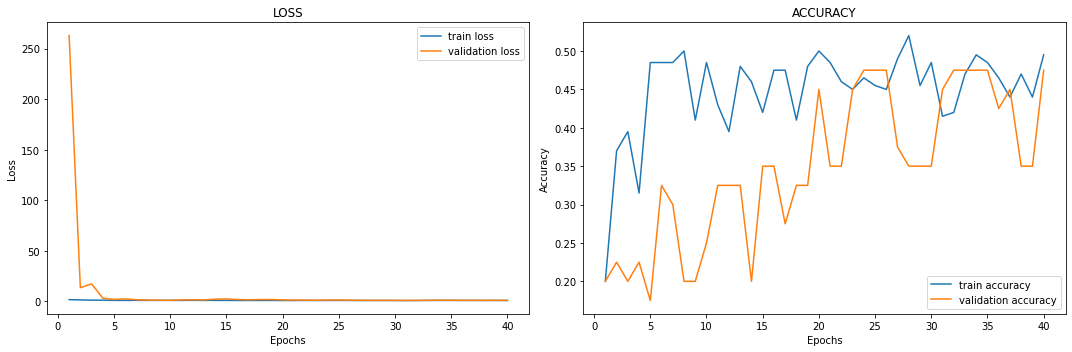

In [58]:
plot_result(history)

In [ ]:
5+5